In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
# Sample from a ring 
def sample_data_ring(r = 1, n = 1024, sigma = 0.1):
    theta = np.random.uniform(low=0.0, high=2*np.pi, size=(n,))
    radius = np.random.randn(n) * sigma + r
    x = radius*np.cos(theta)
    y = radius*np.sin(theta)
    return np.stack((x,y),axis = 1)

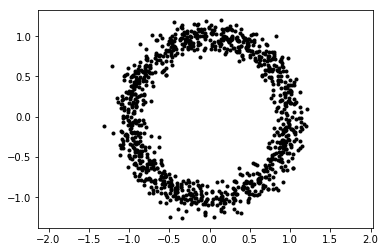

In [3]:
data = sample_data_ring()
plt.plot(data[:,0],data[:,1],'k.')
plt.axis('equal');

In [4]:
# Sample from a "target"
def sample_data_target(r = 2, n = 1024, sigma = 0.2):
    n1 = np.ceil(n/2).astype(int)
    n2 = n-n1
    theta1 = np.random.uniform(low=0.0, high=2*np.pi, size=(n1,))
    theta2 = np.random.uniform(low=0.0, high=2*np.pi, size=(n2,))
    radius1 = np.random.randn(n1) * sigma + r
    radius2 = np.random.randn(n2) * 2*sigma 
    x1 = radius1*np.cos(theta1)
    y1 = radius1*np.sin(theta1)
    x2 = radius2*np.cos(theta2)
    y2 = radius2*np.sin(theta2)
    return np.concatenate((np.stack((x1,y1),axis = 1),np.stack((x2,y2),axis = 1)),axis=0)

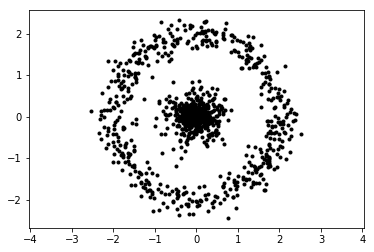

In [5]:
data = sample_data_target()
plt.plot(data[:,0],data[:,1],'k.')
plt.axis('equal');

In [6]:
def generator(Z,hsize=[16,16,16],reuse=False):
    with tf.variable_scope("Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h3,2)
    return out

In [7]:
def discriminator(X,hsize=[16,16,16],reuse=False):
    with tf.variable_scope("Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h3,1)
    return out

In [8]:
def sample_Z(n=1024, dim=2):
    z = np.random.normal(0,1,(n,dim))
    return z

In [9]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [10]:
# set up a grid for visualizing discriminator
grid = np.arange(-3.5,3.5, 0.05)
xv, yv = np.meshgrid(grid, grid)
v = np.concatenate((xv.reshape(-1,1),yv.reshape(-1,1)),axis= 1)

In [11]:
# Build the graph

# set up placeholder for input
X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

# set up the grid
V = tf.constant(v, dtype = tf.float32)

# pass data into generator and discriminator
G_sample = generator(Z)
r_logits = discriminator(X)
f_logits = discriminator(G_sample,reuse=True)
v_logits = discriminator(V,reuse=True)

# loss function for discriminator an dgenerator
disc_loss = 0.5*tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + 0.5*tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

# collect trainable variables for discriminator and generator
disc_vars = [var for var in tf.trainable_variables() if var.name.startswith("Discriminator")]
gen_vars = [var for var in tf.trainable_variables() if var.name.startswith("Generator")]

# set up optimization steps
gen_opt = tf.train.RMSPropOptimizer(learning_rate=0.01).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_opt = tf.train.RMSPropOptimizer(learning_rate=0.01).minimize(disc_loss,var_list = disc_vars) # D Train step


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


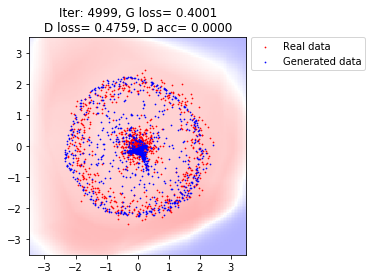

<Figure size 432x288 with 0 Axes>

In [27]:
# Training
batch_size = 1024
epochs = 5000
dim = 2
g_samples = []
r_samples = []
d_accuracy_list = []
gloss_list = []
dloss_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        # train discriminator
        for j in range(5):
            X_batch = sample_data_target(n=batch_size)
            Z_batch = sample_Z(n=batch_size, dim=dim)
            _, dloss = sess.run([disc_opt, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
        dloss_list.append(dloss)
        
        # train generator
        Z_batch2 = sample_Z(n=batch_size, dim=dim)
        _, gloss, gs, flab, v_log = sess.run([gen_opt, gen_loss, G_sample, f_logits, v_logits], feed_dict={Z: Z_batch2})
        gloss_list.append(gloss)

        if i%100 == 0 or i==epochs-1:            
            acc = np.mean(sigmoid(flab)<0.5)
            d_accuracy_list.append(acc)
            g_samples.append(gs)
            r_samples.append(X_batch)
            
            v_pred = sigmoid(v_log).reshape(xv.shape[0], yv.shape[0])
            extent = [-3.525, 3.525, -3.525, 3.525]
                       
            plt.clf()
            plt.imshow(v_pred, extent = extent, alpha = 0.3, cmap = 'bwr')
            plt.scatter(r_samples[-1][:,0],r_samples[-1][:,1], s = 0.5,c = 'r',label='Real data')
            plt.scatter(g_samples[-1][:,0],g_samples[-1][:,1], s = 0.5,c = 'b',label='Generated data')
            plt.xlim([-3.5,3.5])
            plt.ylim([-3.5,3.5])
            plt.legend(frameon=False)
            plt.legend(bbox_to_anchor = (1.02,1), loc = 2, borderaxespad = 0.)
            plt.title("Iter: %d, G loss= %.4f\nD loss= %.4f, D acc= %.4f"%(i,gloss,dloss,acc));
            display.clear_output(wait=True)
            display.display(plt.gcf());

plt.clf();

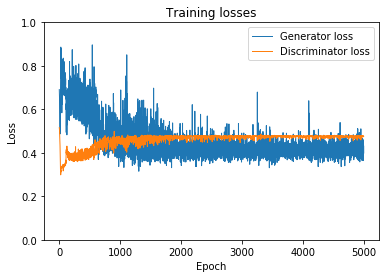

In [29]:
# Plot training losses
plt.plot(gloss_list,linewidth = 1,label='Generator loss')
plt.plot(dloss_list,linewidth = 1,label='Discriminator loss')
plt.ylim([0,1])
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training losses');

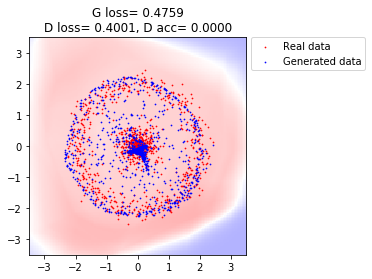

In [30]:
# Plot generated data
plt.imshow(v_pred, extent = extent, alpha = 0.3, cmap = 'bwr')
plt.scatter(r_samples[-1][:,0],r_samples[-1][:,1], s = 0.5,c = 'r',label='Real data')
plt.scatter(g_samples[-1][:,0],g_samples[-1][:,1], s = 0.5,c = 'b',label='Generated data')
plt.xlim([-3.5,3.5])
plt.ylim([-3.5,3.5])
plt.legend(frameon=False)
plt.legend(bbox_to_anchor = (1.02,1), loc = 2, borderaxespad = 0.)
plt.title("G loss= %.4f\nD loss= %.4f, D acc= %.4f"%(dloss_list[-1],gloss_list[-1],d_accuracy_list[-1]));